C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_i

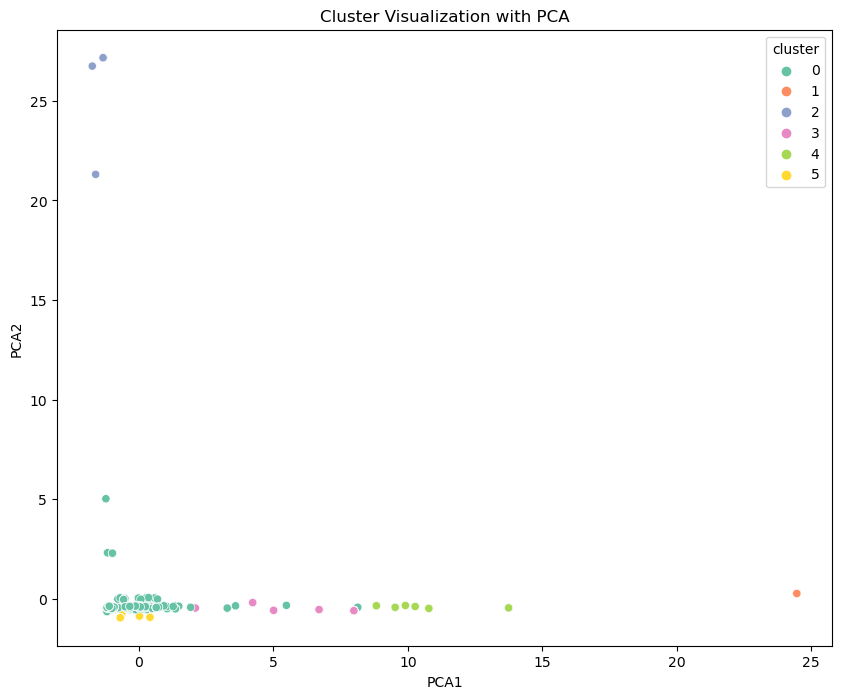

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data.csv')
df = df[~df['tags'].str.contains('shorts', case=False, na=False)]

# Ensure 'tags' is a list of strings and exclude non-strings or malformed data
df['tags'] = df['tags'].fillna('').str.split(', ').apply(lambda x: list(set(x)))

# Count the occurrence of each tag
tag_counts = df.explode('tags')['tags'].value_counts()

# Select the top 50 tags
top_50_tags = tag_counts.head(50).index

# Create a binary matrix for the presence of top 50 tags
binary_matrix = pd.DataFrame(index=df.index)
for tag in top_50_tags:
    binary_matrix[tag] = df['tags'].apply(lambda tags: 1 if tag in tags else 0)

# Add 'liked' and 'subscribed' columns to the binary matrix
binary_matrix['liked'] = df['liked'].astype(int)
binary_matrix['subscribed'] = df['subscribed'].astype(int)

# Normalize the feature matrix
scaler = StandardScaler()
X_scaled = scaler.fit_transform(binary_matrix)

# Finding the optimal number of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2

# Clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df, palette='Set2')
plt.title('Cluster Visualization with PCA')
plt.show()


In [21]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data.csv')
df = df[~df['tags'].str.contains('shorts', case=False, na=False)]

# Ensure 'tags' column is in the correct format for processing
def clean_tags(tag_string):
    if pd.isna(tag_string):
        return []
    return tag_string.strip("[]").replace("'", "").split(", ")

df['tags'] = df['tags'].apply(clean_tags)

# Identify Top Channels
top_channels = df['channelTitle'].value_counts().head(10).index.tolist()

# Identify Top Tags
vectorizer = TfidfVectorizer(max_features=500)
X_tags = vectorizer.fit_transform(df['tags'].apply(lambda x: " ".join(x)))
tags_sum = np.array(X_tags.sum(axis=0)).flatten()
top_tags = vectorizer.get_feature_names_out()[tags_sum.argsort()[-500:]]

# OneHotEncode the top channels
channel_enc = OneHotEncoder(categories=[top_channels], handle_unknown='ignore')
channel_features = channel_enc.fit_transform(df[['channelTitle']].fillna('Unknown')).toarray()

# TF-IDF for the top tags
tfidf_enc = TfidfVectorizer(vocabulary=top_tags)
tag_features = tfidf_enc.fit_transform(df['tags'].apply(lambda x: " ".join(x))).toarray()

# Combine Features including 'liked' and 'subscribed'
X_combined = np.hstack((channel_features, tag_features, df[['liked', 'subscribed']].values))

# Normalize numerical features
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined)

# Find optimal number of clusters using the elbow method or other criteria
# This is an example; you might have a different method to determine the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_combined_scaled)

# Assign cluster labels to the original dataframe
df['cluster'] = kmeans.labels_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [22]:
from sklearn.decomposition import PCA
import plotly.express as px

# Apply PCA for dimensionality reduction for visualization purposes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_combined_scaled)

# Create a new DataFrame for the PCA results
df_pca = pd.DataFrame(pca_result, columns=['PCA Feature 1', 'PCA Feature 2'])

# Merge the PCA results and clusters back to the original dataframe
df_merged = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

# Create a Plotly Express scatter plot for the PCA results with clusters
fig = px.scatter(
    df_merged, x='PCA Feature 1', y='PCA Feature 2',
    color=df_merged['cluster'].astype(str),  # Convert cluster labels to string for discrete colors
    title='Interactive Clusters of YouTube Videos with Top Channels and Tags'
)

# Show the figure
fig.show()


In [23]:
# Analysis of each cluster
for cluster_id in range(kmeans.n_clusters):
    cluster_data = df_merged[df_merged['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"Average Views: {cluster_data['viewCount'].mean()}")
    print(f"Average Likes: {cluster_data['likeCount'].mean()}")
    print(f"Percentage of Liked Videos: {cluster_data['liked'].mean() * 100}%")
    print(f"Percentage of Videos from Subscribed Channels: {cluster_data['subscribed'].mean() * 100}%")
    # Add additional analyses as needed



Cluster 0:
Average Views: 323123.42076502735
Average Likes: 4769.737704918033
Percentage of Liked Videos: 99.18032786885246%
Percentage of Videos from Subscribed Channels: 100.0%

Cluster 1:
Average Views: 33209885.937610723
Average Likes: 544251.3985986648
Percentage of Liked Videos: 5.635590718545197%
Percentage of Videos from Subscribed Channels: 25.64208537521403%

Cluster 2:
Average Views: 331666.0
Average Likes: 4156.0
Percentage of Liked Videos: 0.0%
Percentage of Videos from Subscribed Channels: 100.0%

Cluster 3:
Average Views: 107052920.68382353
Average Likes: 1184272.5820895522
Percentage of Liked Videos: 2.2058823529411766%
Percentage of Videos from Subscribed Channels: 5.88235294117647%

Cluster 4:
Average Views: 2142057.217391304
Average Likes: 69202.59782608696
Percentage of Liked Videos: 0.0%
Percentage of Videos from Subscribed Channels: 100.0%

Cluster 5:
Average Views: 461691694.27402866
Average Likes: 2846911.0040899795
Percentage of Liked Videos: 99.18200408997954

In [24]:
# Calculating distances from each point to its cluster center
distances = kmeans.transform(X_combined_scaled)

# Defining a threshold for outliers (e.g., 95th percentile)
outlier_threshold = np.percentile(distances, 95)

# Identifying outliers
outliers = df_merged[np.any(distances > outlier_threshold, axis=1)]

# Analyzing outliers
print("\nOutliers:")
print(outliers[['title', 'channelTitle', 'viewCount', 'likeCount']])



Outliers:
                                                   title  \
13     Youtube API for Python: How to Create a Unique...   
14     Python Project to Scrape YouTube using YouTube...   
61              MOTIVE - EXORCIST (Official Music Video)   
62              MOTIVE - EXORCIST (Official Music Video)   
63              MOTIVE - EXORCIST (Official Music Video)   
...                                                  ...   
35925  50 People Show Us Their States' Accents | Cult...   
35931  Better Call Saul's Most Tragic Character - How...   
35937  How That ‘Better Call Saul’ Death Was Kept Sec...   
35941                   One Year Beard Growth Time-Lapse   
35943  'Better Call Saul' Fan Theories with Bob Odenk...   

                channelTitle   viewCount  likeCount  
13     Thu Vu data analytics     58192.0     2700.0  
14                   techTFQ    106126.0     3224.0  
61                    Motive   5479100.0    55749.0  
62                    Motive   5479100.0    55749.0 

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np

# Load dataset
df = pd.read_csv('data.csv').drop_duplicates()

df = df.dropna(subset=['viewCount', 'subscribed'])

# Handle missing values in 'tags' column
df['tags'].fillna('', inplace=True)

# Tokenize Tags
df['tags'] = df['tags'].apply(lambda x: x.split(', ') if x != '' else [])

# Flatten the list of tags and get the most common tags
all_tags = [tag for sublist in df['tags'] for tag in sublist]
tag_counts = pd.Series(all_tags).value_counts()
n = 500  # Adjust 'n' based on your requirement
top_tags = tag_counts.head(n).index.tolist()

# Create a dictionary mapping each tag to a unique index
tag_to_index = {tag: index for index, tag in enumerate(top_tags)}

# Convert tags of each video to binary representation
def tags_to_binary(tag_list):
    tag_presence = [0] * n
    for tag in tag_list:
        if tag in tag_to_index:
            tag_presence[tag_to_index[tag]] = 1
    return tag_presence

df['tag_binary'] = df['tags'].apply(tags_to_binary)


# Feature Preparation
X = pd.DataFrame(df['tag_binary'].tolist(), index=df.index)
# Add other relevant features to X if needed

# Target Variable Preparation
y_views = df['liked'].astype(int)
y_subscribed = df['subscribed'].astype(int)  # Ensure this is a binary column

# Model Training for ViewCount
X_train, X_test, y_train, y_test = train_test_split(X, y_views, test_size=0.2, random_state=42)
model_views = RandomForestRegressor(n_estimators=100, random_state=42)
model_views.fit(X_train, y_train)

# Predictions and Evaluation for ViewCount
y_pred_views = model_views.predict(X_test)
mse_views = mean_squared_error(y_test, y_pred_views)
print(f"Mean Squared Error for Viewed Prediction: {mse_views}")

# Model Training for Subscribed
X_train, X_test, y_train, y_test = train_test_split(X, y_subscribed, test_size=0.2, random_state=42)
model_subscribed = RandomForestRegressor(n_estimators=100, random_state=42)
model_subscribed.fit(X_train, y_train)

# Predictions and Evaluation for Subscribed
y_pred_subscribed = model_subscribed.predict(X_test).round()  # Round to get binary predictions
accuracy_subscribed = accuracy_score(y_test, y_pred_subscribed)
print(f"Accuracy for Subscribed Prediction: {accuracy_subscribed}")


Mean Squared Error for View Count Prediction: 0.03737918657539223
Accuracy for Subscribed Prediction: 0.8722490606548577


Hypothesis: "Videos from channels to which a user is subscribed tend to have a higher view count compared to videos from non-subscribed channels, possibly due to a higher degree of engagement and interest."